рома бохян

In [1]:
import ast
import gzip
import io
import tarfile
import zipfile
from collections import Counter, OrderedDict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm as tnqdm

from scipy.spatial import Voronoi, distance_matrix

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from catboost import CatBoostRegressor
from joblib import Parallel, delayed
from pymatgen.core import Structure
from pymatgen.core.periodic_table import Element
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

In [2]:
BASES_and_CONCENTRATIONS = [['BP_spin_500', 'high'], ['GaSe_spin_500', 'high'],
                            ['hBN_spin_500', 'high'], ['InSe_spin_500', 'high'],
                            ['MoS2', 'low'], ['MoS2_500', 'high'],
                            ['WSe2', 'low'], ['WSe2_500', 'high']
                           ]


def readStructures(base, concentration, structure_ids):
    
    with zipfile.ZipFile('2d-materials-point-defects-all.zip') as datasets_zip:
        
        base_in_zip = f'{concentration}_density_defects/{base}'
        with tarfile.open(
            fileobj=io.BytesIO(datasets_zip.read(f'{base_in_zip}/initial.tar.gz'))
        ) as tf:
            cifs = [tf.extractfile(f'{_id}.cif').read().decode("utf-8") 
                    for _id in tqdm(structure_ids)]

    return pd.DataFrame(cifs, index=structure_ids, columns=['cif'])

def parseStructure(cif_string):

    structure = Structure.from_str(cif_string, fmt='cif') #.get_structures(primitive=False)[0]
    space_group_number = SpacegroupAnalyzer(structure).get_space_group_number()
    lattice = structure.lattice.matrix
    positions = np.array([x.coords for x in structure])
    atomic_symbols = np.array(list(map(lambda x: x.symbol, structure.species)))
    atomic_numbers = np.array(list(map(lambda x: Element(x).number, atomic_symbols)))
    formula = OrderedDict(sorted(Counter(atomic_symbols).items()))
    return [space_group_number, lattice, positions, atomic_symbols, atomic_numbers, formula, 
                         len(atomic_numbers), len(formula)]


def structureFormationEnergy(structure, neat_elements):

    fe = structure['energy']
    formula = structure['formula']
    for element in formula.keys() :
        element_chem_potential = neat_elements.loc[element]['chemical_potential']
        fe -= formula[element] * element_chem_potential
    return fe


def flatList(list_):
    
    return [str(item) for sublist in list_ for item in sublist]


def readDataFromArchive(base, concentration):

    with zipfile.ZipFile('2d-materials-point-defects-all.zip') as datasets_zip:

        base_in_zip = f'{concentration}_density_defects/{base}'

        with datasets_zip.open(f'{base_in_zip}/defects.csv.gz') as defects_gz :
            with gzip.open(defects_gz) as defects_data :
                defects_df = pd.read_csv(defects_data, sep=',')

        with datasets_zip.open(f'{base_in_zip}/descriptors.csv') as descriptors :
            descriptors_df = pd.read_csv(descriptors, sep=',')

        with datasets_zip.open(f'{base_in_zip}/elements.csv') as elements :
            neat_elements_df = pd.read_csv(elements, sep=',')
        neat_elements_df.set_index('element', inplace=True, drop=True)
        print(neat_elements_df)

        with datasets_zip.open(f'{base_in_zip}/initial_structures.csv') as init_structures :
            init_structures_df = pd.read_csv(init_structures, sep=',')

        with datasets_zip.open(f'{base_in_zip}/targets.csv.gz') as targets_gz :
            with gzip.open(targets_gz) as targets_data :
                targets_df = pd.read_csv(targets_data, sep=',')

    return defects_df, descriptors_df, neat_elements_df, init_structures_df, targets_df


def handleTableData(base, concentration) :

    defects_df, descriptors_df, neat_elements_df, init_structures_df, targets_df = \
                                                        readDataFromArchive(base, concentration)
    print('\n' + '*'*90 + '\n')
    
    print(f'Information on defects.csv.gz for {base}_{concentration}_concentration')
    for unused_property in ['Unnamed: 0', 'defect_id'] :
        if unused_property in defects_df.columns:
            defects_df.drop(unused_property, axis=1, inplace=True)
    print('\tcolumns:', defects_df.columns)
    print('\tshape:', defects_df.shape)
    number_of_unique = len(defects_df['_id'].unique())
    print(f'\t{number_of_unique} unique defect structures')
    number_of_unique = len(defects_df['descriptor_id'].unique())
    print(f'\t{number_of_unique} unique defect descriptors')

    print(f'Information on descriptors.csv for {base}_{concentration}_concentration')
    for unused_property in ['Unnamed: 0', 'defect_id'] :
        if unused_property in descriptors_df.columns:
            descriptors_df.drop(unused_property, axis=1, inplace=True)
    print('\tcolumns:', descriptors_df.columns)
    print('\tshape:', descriptors_df.shape)
    number_of_unique = len(descriptors_df['_id'].unique())
    print(f'\t{number_of_unique} unique defect descriptors')

    print(f'Information on targets.csv for {base}_{concentration}_concentration')
    for unused_property in ['Unnamed: 0', 'defect_id'] :
        if unused_property in targets_df.columns:
            targets_df.drop(unused_property, axis=1, inplace=True)
    print('\tcolumns:', targets_df.columns)
    print('\tshape:', targets_df.shape)
    number_of_unique = len(targets_df['_id'].unique())
    print(f'\t{number_of_unique} unique defect structures')
    number_of_unique = len(targets_df['descriptor_id'].unique())
    print(f'\t{number_of_unique} unique defect descriptors')

    print('\n' + '*'*90 + '\n')
    print('Data checking...')
    print(f'Is \'descriptor_id\'s (defects.csv) a subset of \'_id\'s (descriptors.csv)?', 
          set(defects_df['descriptor_id']).issubset(set(descriptors_df['_id'])))

    defects_df.set_index('_id', inplace=True, drop=True)
    targets_df.set_index('_id', inplace=True, drop=True)
    descriptors_df.set_index('_id', inplace=True, drop=True)        

    data = pd.DataFrame(descriptors_df.loc[defects_df['descriptor_id']].values, 
                                    columns=descriptors_df.columns, index=defects_df.index)

    for additional_data in [defects_df, targets_df] :
        for piece_of_data in additional_data.columns :
            if (piece_of_data in data.columns) and (additional_data[piece_of_data].dtype != 'O') :
                diff = additional_data[piece_of_data] - data[piece_of_data]
                out_ = np.abs(diff).max()
                print(f'{piece_of_data:>21s} is in the data with the maximum difference of {out_}')
            elif (piece_of_data in data.columns) and (additional_data[piece_of_data].dtype == 'O') :
                out_ = all(data[piece_of_data] == additional_data[piece_of_data])
                print(f'{piece_of_data:>21s} is in the data. Are the column contents the same? {out_}')
            else:
                data[piece_of_data] = additional_data[piece_of_data]

    print('\n' + '*'*90 + '\n')
    cells_available = sorted(data['cell'].unique())
    print('Unique supercells:', cells_available)
    print('\n' + '*'*90 + '\n')
    
    data['defects'] = data['defects'].apply(ast.literal_eval)
    data['defect_nsites'] = data['defects'].apply(len)
                    
    return (data, neat_elements_df, init_structures_df)


def prepareBaseConcentrationDataset(base, concentration, save_to_file=False) :

    data, neat_elements, _ = handleTableData(base, concentration)

    print('Reading structures...')
    structures = readStructures(base, concentration, data.index)
    data = pd.concat((data, structures), axis=1)

    # parse structural info
    print('Parsing structural information...')
    additional_data = Parallel(n_jobs=-1)(delayed(parseStructure)\
                                     (data.loc[_id].cif) 
                                     for _id in tqdm(data.index))
    additional_data = pd.DataFrame(additional_data, index=data.index, 
                        columns=['space_group_no', 'lattice', 'atomic_positions', 'atomic_symbols', 
                                           'atomic_numbers', 'formula', 'nsites', 'nspecies'])

    data = pd.concat((data, additional_data), axis=1)

    # collect additional data
    data['defect_concentration'] = concentration
    data['structure_formation_energy'] = [structureFormationEnergy(data.loc[i], neat_elements) 
                                             for i in data.index]
    data['structure_formation_energy_per_atom'] = data['structure_formation_energy'] / data['nsites']
    data['composition_string'] = data['formula'].apply(lambda x: '_'.join(flatList(list(x.items()))))

    data = data[sorted(data.columns)]
    
    if save_to_file :
        data.to_pickle(f'2d-base_{base}-{concentration}_defect_concentration-table.pkl.gz')
    
    return data


def prepareFullDataset(save_to_file=True, filename='2d-materials-point-defects-all-table.pkl.gz'):

    base_datasets = [prepareBaseConcentrationDataset(base, concentration) 
                         for base, concentration in BASES_and_CONCENTRATIONS]
    
    full_dataset = pd.concat(base_datasets, axis=0)

    full_dataset['ordinal_id'] = list(map(float, range(full_dataset.shape[0])))
    full_dataset = full_dataset[sorted(full_dataset.columns)]
    print(f'Full dataset shape is {full_dataset.shape}')
    
    if save_to_file:
        full_dataset.to_pickle(filename)
        return None
    
    else:
        return full_dataset

In [3]:
%%time
if not os.path.isfile('2d-materials-point-defects-all-table.pkl.gz') :
    #url_main = 'https://rolos.com/open/2d-materials-point-defects/attachments'
    url_main = 'https://research.constructor.tech/open/2d-materials-point-defects/attachments'
    url_attach = 'b62e17e599364a12941a9ae494a14736?name=2d-materials-point-defects-all.zip'
    request = requests.get('/'.join([url_main, url_attach]), allow_redirects=True)
    open('2d-materials-point-defects-all.zip', 'wb').write(request.content)
    print('\nThe dataset has been successfully downloaded and is currently being processed!\n')

    prepareFullDataset()
    
else :
    print('\nThe dataset was downloaded and processed previously!\n')


The dataset was downloaded and processed previously!

CPU times: user 32 μs, sys: 20 μs, total: 52 μs
Wall time: 49.8 μs


In [4]:
full_dataset = pd.read_pickle('2d-materials-point-defects-all-table.pkl.gz')
print(f'Dataset shape (objects, features) is {full_dataset.shape}')
print(f'Number of unique structure ids is {len(full_dataset.index.unique())}')

Dataset shape (objects, features) is (14866, 58)
Number of unique structure ids is 14866


In [5]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14866 entries, P_P141N1_dd6a5668-efc9-4f4c-aee8-ac3472eaf09f to WSe2_Mo4W56Se112S8_e7031dcd-1621-4756-bd39-273b0b78aea9
Data columns (total 58 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   E_1                                  12866 non-null  float64
 1   E_1_majority                         2500 non-null   float64
 2   E_1_max                              500 non-null    float64
 3   E_1_min                              500 non-null    float64
 4   E_1_minority                         2500 non-null   float64
 5   atomic_numbers                       14866 non-null  object 
 6   atomic_positions                     14866 non-null  object 
 7   atomic_symbols                       14866 non-null  object 
 8   band_gap                             11866 non-null  float64
 9   base                                 14866 non-null  object 
 10  cell 

In [6]:
full_dataset.describe()

,E_1,E_1_majority,E_1_max,E_1_min,E_1_minority,band_gap,defect_nsites,energy,energy_per_atom,fermi_level,...,normalized_lumo_max,normalized_lumo_min,normalized_lumo_minority,nsites,nspecies,ordinal_id,space_group_no,structure_formation_energy,structure_formation_energy_per_atom,total_mag
count,12866.000000,2500.000000,500.000000,500.000000,2500.000000,11866.000000,14866.000000,14866.000000,14866.000000,14866.000000,...,14866.000000,14866.000000,14866.000000,14866.000000,14866.000000,14866.000000,14866.000000,14866.000000,14866.000000,14866.000000
mean,-50.818971,-28.720294,-63.258900,-63.258900,-28.713885,0.860249,4.676981,-1282.537528,-6.963258,-0.703480,...,11.954299,11.935805,11.936493,182.671801,3.256491,7432.500000,2.419682,-121.530824,-0.658432,0.157020
std,19.742458,17.479992,0.190076,0.190076,17.481816,0.541578,4.357694,242.172539,0.972256,0.774584,...,19.343678,19.351014,19.350721,19.071423,0.691644,4291.588886,8.721758,41.734492,0.219333,0.668404
min,-63.790200,-63.790200,-63.790200,-63.790200,-63.790200,0.029700,1.000000,-1402.841228,-8.762722,-4.398558,...,0.512900,0.279600,0.279600,120.000000,1.000000,0.000000,1.000000,-169.965611,-1.202269,0.000000
25%,-61.770000,-25.210900,-63.389050,-63.389050,-25.197525,0.366225,3.000000,-1385.256892,-7.234144,-0.531920,...,1.084025,1.083300,1.083300,189.000000,3.000000,3716.250000,1.000000,-162.401488,-0.850401,0.000000
50%,-61.712200,-20.582950,-63.250550,-63.250550,-20.574250,0.859100,3.000000,-1372.327458,-7.215027,-0.347863,...,1.202300,1.202200,1.202200,190.000000,3.000000,7432.500000,1.000000,-106.802777,-0.556309,0.000000
75%,-61.581300,-17.938575,-63.129175,-63.129175,-17.938575,1.282075,3.000000,-1361.492565,-7.166001,-0.300586,...,5.063375,4.597175,4.608350,191.000000,4.000000,11148.750000,1.000000,-98.140537,-0.519633,0.000000
max,-15.442500,-16.367000,-62.907300,-62.907300,-16.367000,1.873700,24.000000,-473.053953,-3.530253,0.002254,...,48.170800,48.170800,48.170800,192.000000,4.000000,14865.000000,187.000000,20.581925,0.152459,9.874075


In [7]:
print(f"Dataset shape: {full_dataset.shape}")
print(f"Columns: {list(full_dataset.columns)}")

print("\nDataset Overview:")
print(full_dataset.info())

Dataset shape: (14866, 58)
Columns: ['E_1', 'E_1_majority', 'E_1_max', 'E_1_min', 'E_1_minority', 'atomic_numbers', 'atomic_positions', 'atomic_symbols', 'band_gap', 'base', 'cell', 'cif', 'composition_string', 'defect_concentration', 'defect_nsites', 'defects', 'description', 'descriptor_id', 'energy', 'energy_per_atom', 'fermi_level', 'formation_energy', 'formation_energy_per_site', 'formula', 'homo', 'homo_lumo_gap', 'homo_lumo_gap_majority', 'homo_lumo_gap_max', 'homo_lumo_gap_min', 'homo_lumo_gap_minority', 'homo_majority', 'homo_max', 'homo_min', 'homo_minority', 'lattice', 'lumo', 'lumo_majority', 'lumo_max', 'lumo_min', 'lumo_minority', 'normalized_homo', 'normalized_homo_majority', 'normalized_homo_max', 'normalized_homo_min', 'normalized_homo_minority', 'normalized_lumo', 'normalized_lumo_majority', 'normalized_lumo_max', 'normalized_lumo_min', 'normalized_lumo_minority', 'nsites', 'nspecies', 'ordinal_id', 'pbc', 'space_group_no', 'structure_formation_energy', 'structure_for

In [8]:
print("\nTarget Variables Statistics:")
print(full_dataset[["structure_formation_energy", "homo_lumo_gap_max"]].describe())

print("\nMissing values in target variables:")
print(full_dataset[["structure_formation_energy", "homo_lumo_gap_max"]].isnull().sum())


Target Variables Statistics:
       structure_formation_energy  homo_lumo_gap_max
count                14866.000000       14866.000000
mean                  -121.530824           0.792593
std                     41.734492           0.572523
min                   -169.965611           0.009200
25%                   -162.401488           0.255275
50%                   -106.802777           0.655300
75%                    -98.140537           1.246400
max                     20.581925           4.597800

Missing values in target variables:
structure_formation_energy    0
homo_lumo_gap_max             0
dtype: int64


# часть выше позаимствовал из ноутбука с гита, чтобы запустить модель фулл верном готовом датасете, мой код начинатеся отсюда и все что нише !

в качестве модели я выбрал voronoi rf, так как мой комп с гпу успешно умер а часы колаба и кагла я потратил, в целом правил не нарушает поэтому воот. так как так же возникли трудности с тем чтобы просто скачать модель voronoi rf (tbh очень не френдли в целом все модели с сайта как то( ) я решил его просто реализовать самостоятельно - VoronoiRF это случайны лес обученный прогнозировать энергию образование кристаллов на основе комбинации - композиционные признаки magpie + cтруктурные признаки излвеченные из voronoi кристаллической решетки. то есть вот есть признаки для каждого строится его voronoi cell (область точек ближе всех к данному признаку) затем вычисляется характеристики воронового. я реализую сам некую часть кода для интереса да и просто чтобы у меня все завелось по человече. я попробую поиграться с фичами, главное правило что конечно же там не будет таргетов, но в остальном я себя не огранчииваю. так же я попробую подкрутить помимо RF еше модели

In [9]:
df = pd.read_pickle("2d-materials-point-defects-all-table.pkl.gz")
print(f"Shape: {df.shape}")
print("Columns:", df.columns.tolist())
df.head()

Shape: (14866, 58)
Columns: ['E_1', 'E_1_majority', 'E_1_max', 'E_1_min', 'E_1_minority', 'atomic_numbers', 'atomic_positions', 'atomic_symbols', 'band_gap', 'base', 'cell', 'cif', 'composition_string', 'defect_concentration', 'defect_nsites', 'defects', 'description', 'descriptor_id', 'energy', 'energy_per_atom', 'fermi_level', 'formation_energy', 'formation_energy_per_site', 'formula', 'homo', 'homo_lumo_gap', 'homo_lumo_gap_majority', 'homo_lumo_gap_max', 'homo_lumo_gap_min', 'homo_lumo_gap_minority', 'homo_majority', 'homo_max', 'homo_min', 'homo_minority', 'lattice', 'lumo', 'lumo_majority', 'lumo_max', 'lumo_min', 'lumo_minority', 'normalized_homo', 'normalized_homo_majority', 'normalized_homo_max', 'normalized_homo_min', 'normalized_homo_minority', 'normalized_lumo', 'normalized_lumo_majority', 'normalized_lumo_max', 'normalized_lumo_min', 'normalized_lumo_minority', 'nsites', 'nspecies', 'ordinal_id', 'pbc', 'space_group_no', 'structure_formation_energy', 'structure_formation_e

,E_1,E_1_majority,E_1_max,E_1_min,E_1_minority,atomic_numbers,atomic_positions,atomic_symbols,band_gap,base,...,normalized_lumo_min,normalized_lumo_minority,nsites,nspecies,ordinal_id,pbc,space_group_no,structure_formation_energy,structure_formation_energy_per_atom,total_mag
_id,,,,,,,,,,,,,,,,,,,,,
P_P141N1_dd6a5668-efc9-4f4c-aee8-ac3472eaf09f,NaN,-20.2110,NaN,NaN,-20.1964,"[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[[-1.6581177620044923e-16, 2.707911804708, 4.1...","[P, P, P, P, P, P, P, P, P, P, P, P, P, P, P, ...",NaN,P,...,3.8959,3.8959,142,2,0.0,NaN,1,4.203326,0.029601,0.373540
P_P141N1_2a285334-f6b0-498c-bb4a-788bfd4af4a6,NaN,-20.1189,NaN,NaN,-20.1178,"[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[[-1.6581177620044923e-16, 2.707911804708, 4.1...","[P, P, P, P, P, P, P, P, P, P, P, P, P, P, P, ...",NaN,P,...,3.8187,3.8192,142,2,1.0,NaN,1,3.574339,0.025171,0.274071
P_P141_83ddad39-bb28-4896-93f3-a97b8664304f,NaN,-17.2629,NaN,NaN,-17.2612,"[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[[-1.6581177620044923e-16, 2.707911804708, 4.1...","[P, P, P, P, P, P, P, P, P, P, P, P, P, P, P, ...",NaN,P,...,0.6254,0.6346,141,1,2.0,NaN,1,4.348573,0.030841,0.973272
P_P141N1_64f2c31f-7207-4897-9877-60187bcb87d4,NaN,-20.3546,NaN,NaN,-20.3553,"[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[[-1.6581177620044923e-16, 2.707911804708, 4.1...","[P, P, P, P, P, P, P, P, P, P, P, P, P, P, P, ...",NaN,P,...,4.0533,4.0591,142,2,3.0,NaN,1,3.872619,0.027272,1.862092
P_P141N1_af730d2e-7790-46db-8751-75e46bf49b68,NaN,-20.2375,NaN,NaN,-20.2376,"[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[[-1.6581177620044923e-16, 2.707911804708, 4.1...","[P, P, P, P, P, P, P, P, P, P, P, P, P, P, P, ...",NaN,P,...,3.7035,3.7042,142,2,4.0,NaN,1,4.225528,0.029757,0.142128


так, ну таргета у нас два - энергии формирования кристалла и HOMO-LUMO gap

In [10]:
df.columns

Index(['E_1', 'E_1_majority', 'E_1_max', 'E_1_min', 'E_1_minority',
       'atomic_numbers', 'atomic_positions', 'atomic_symbols', 'band_gap',
       'base', 'cell', 'cif', 'composition_string', 'defect_concentration',
       'defect_nsites', 'defects', 'description', 'descriptor_id', 'energy',
       'energy_per_atom', 'fermi_level', 'formation_energy',
       'formation_energy_per_site', 'formula', 'homo', 'homo_lumo_gap',
       'homo_lumo_gap_majority', 'homo_lumo_gap_max', 'homo_lumo_gap_min',
       'homo_lumo_gap_minority', 'homo_majority', 'homo_max', 'homo_min',
       'homo_minority', 'lattice', 'lumo', 'lumo_majority', 'lumo_max',
       'lumo_min', 'lumo_minority', 'normalized_homo',
       'normalized_homo_majority', 'normalized_homo_max',
       'normalized_homo_min', 'normalized_homo_minority', 'normalized_lumo',
       'normalized_lumo_majority', 'normalized_lumo_max',
       'normalized_lumo_min', 'normalized_lumo_minority', 'nsites', 'nspecies',
       'ordinal_id', '

In [11]:
print(df.isnull().sum().sort_values(ascending=False).head(10))

E_1_max            14366
E_1_min            14366
E_1_minority       12366
E_1_majority       12366
pbc                 3000
band_gap            3000
homo_lumo_gap       2000
normalized_lumo     2000
normalized_homo     2000
homo                2000
dtype: int64


In [12]:
print("before:", df.shape)
df = df.dropna(subset=["formation_energy", "homo_lumo_gap"])
print("after:", df.shape)

before: (14866, 58)
after: (12866, 58)


attempt 1

тут у меня будут танцы с бубнами чтобы избежать оверфита тк в датасете есть одна особенноть - там много признаков которые напрямую связаны с таргетами или вычисляются из него, чтобы избежать ликов я прибегну к жесткой чистке

так ну для начада надо избавиться от дубликатов путем создания уникального ключа и порядкого номера и определить таргет

In [13]:
if "ordinal_id" in df.columns and "composition_string" in df.columns:
    df["unique_key"] = df["composition_string"] + "_" + df["ordinal_id"].astype(str)
    df = df.drop_duplicates("unique_key")

y_energy = df["formation_energy"].values

y_gap = df["homo_lumo_gap"].values

как я и сказал я буду использовать voronoi для которых нужны вспомогательные функции парсинга и агрегации нечисловых фичей

In [14]:
def safe_parse(x):
    # Если значение — строка, оцениваем через literal_eval, иначе возвращаем как есть
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x


def agg_numbers(x):
    # Для списков чисел возвращаем среднее, сто, длину и число уникальных
    arr = np.array(safe_parse(x))
    return arr.mean(), arr.std(), arr.size, len(set(arr))


def agg_positions(x):
    # Для массива координат считаем расстояния до центра масс:
    # среднее, сто и количество точек
    arr = np.array(safe_parse(x))
    centroid = arr.mean(axis=0)
    dists = np.linalg.norm(arr - centroid, axis=1)
    return dists.mean(), dists.std(), arr.shape[0]


def agg_symbols(x):
    # Для списка химических символов — число элементов и число уникальных
    arr = list(safe_parse(x))
    return len(arr), len(set(arr))


def agg_formula(x):
    # Для словаря формулы — число разных элементов и общее число атомов
    d = dict(safe_parse(x))
    return len(d), sum(d.values())

# Вычисление признаков на основе Voronoi-разбиения
def voronoi_feats(pos_list, jitter=1e-6):
    """
    Возвращает:
      - mean number of Voronoi neighbors
      - mean nearest-neighbor distance
    Еслии невозможно построить ячейки, возвращает (nan, nan).
    """
    try:
        vor = Voronoi(pos_list, qhull_options="QJ")
    except (qhull.QhullError, ValueError):
        pts = pos_list + np.random.normal(scale=jitter, size=pos_list.shape)
        try:
            vor = Voronoi(pts, qhull_options="QJ")
        except (qhull.QhullError, ValueError):
            return np.nan, np.nan

    # Считаем число соседей 
    neigh = [np.sum(vor.ridge_points == i) for i in range(len(pos_list))]
    mean_neighbors = np.mean(neigh)

    # Ближайшие соседи по евклиду
    dists = distance_matrix(pos_list, pos_list)
    np.fill_diagonal(dists, np.inf)
    mean_nn = np.min(dists, axis=1).mean()

    return mean_neighbors, mean_nn

так как в датасете есть признаки которые описываются числовыми значениями я их агрегирую

In [15]:
(df["atomic_numbers_mean"],
    df["atomic_numbers_std"],
    df["atomic_numbers_count"],
    df["atomic_numbers_unique"],) = zip(*df["atomic_numbers"].map(agg_numbers))
(df["atomic_positions_mean_dist"],
    df["atomic_positions_std_dist"],
    df["atomic_positions_count"],) = zip(*df["atomic_positions"].map(agg_positions))
df["atomic_symbols_count"], df["atomic_symbols_unique"] = zip(
    *df["atomic_symbols"].map(agg_symbols)
)
df["formula_count"], df["formula_sum"] = zip(*df["formula"].map(agg_formula))
df["defects_count"] = df["defects"].map(lambda x: len(safe_parse(x)))

для каждого кристалла считаем вороной-признаки 

In [16]:
vor_nb, vor_dist = [], []
for pos in tqdm(df["atomic_positions"], desc="Voronoi"):
    arr = np.array(safe_parse(pos))
    nb, nd = voronoi_feats(arr)
    vor_nb.append(nb)
    vor_dist.append(nd)
df["voronoi_mean_neighbors"] = vor_nb
df["voronoi_mean_nn_dist"] = vor_dist
   

Voronoi:   0%|          | 0/12866 [00:00<?, ?it/s]

In [17]:
print("band_gap stats:\n", df["homo_lumo_gap"].describe())
print("Unique band_gap values:", df["homo_lumo_gap"].nunique())

band_gap stats:
 count    12866.000000
mean         0.783519
std          0.583094
min          0.009200
25%          0.214200
50%          0.416050
75%          1.270675
max          1.873700
Name: homo_lumo_gap, dtype: float64
Unique band_gap values: 4908


теперь важно объяснить выбор признаков -так как модель voronoi RF то важно чтобы среди признаков были признаки Voronoi клетки, а что насчет остальных? явно исключаем признаки которые влияют на таргет - прежде всего убираю счетчкики которые коррелируют с  atomic_positions_count тк они ~= nsites и atomic_numbers_unique тк они ~= c nspecies, так как рендом форест это дерево то там любая сильная мультиколлинеарность может сильно помешать. так же я конечно убираю всякие *homo* признаки тк они БУКВАЛЬНО характеристики таргета, поэтому убираем их тоже. Так же мне интересно будет попробовать обучить модель только на voronoi фичах и посмотреть, мб в такой комбинации выйдет чета крутое 

In [18]:
base_feats = [
    "nsites",
    "nspecies",
    "space_group_no",
]  # баз фичи о кристалле: число сайтов, число видов элементов, группа симметрии
chem_feats = [
    "atomic_numbers_mean",
    "atomic_numbers_std",
]  # химич статистики: среднее и диспер атомного номера
struct_feats = [
    "atomic_positions_mean_dist",
    "atomic_positions_std_dist",
    "voronoi_mean_neighbors",
    "voronoi_mean_nn_dist",
]  # стуктур признаки: плотность упаковки и параметры соседства

energy_feats = base_feats + chem_feats + struct_feats
band_gap_feats = base_feats + chem_feats + struct_feats 

X_energy = df[energy_feats].copy()
X_gap = df[band_gap_feats].copy()

if "base" in df.columns:
    X_energy["base"] = df["base"]
    X_gap["base"] = df["base"]
    ohe = OneHotEncoder(drop="first", sparse_output=False)
    base_ohe = pd.DataFrame(
        ohe.fit_transform(df[["base"]]),
        columns=ohe.get_feature_names_out(["base"]),
        index=df.index,
    )
    X_energy = pd.concat([X_energy.drop("base", axis=1), base_ohe], axis=1)
    X_gap = pd.concat([X_gap.drop("base", axis=1), base_ohe], axis=1)

Xe_tr, Xe_te, ye_tr, ye_te = train_test_split(
    X_energy, y_energy, test_size=0.2, random_state=42
)
Xg_tr, Xg_te, yg_tr, yg_te = train_test_split(
    X_gap, y_gap, test_size=0.2, random_state=42
)

num_e = Xe_tr.select_dtypes(include=[np.number]).columns
num_g = Xg_tr.select_dtypes(include=[np.number]).columns

pre_e = ColumnTransformer([("scale", StandardScaler(), num_e)], remainder="passthrough")
pre_g = ColumnTransformer([("scale", StandardScaler(), num_g)], remainder="passthrough")

pipe_e = make_pipeline(
    pre_e, RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)
pipe_g = make_pipeline(
    pre_g, RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipe_e.fit(Xe_tr, ye_tr)
pipe_g.fit(Xg_tr, yg_tr)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  Index(['nsites', 'nspecies', 'space_group_no', 'atomic_numbers_mean',
       'atomic_numbers_std', 'atomic_positions_mean_dist',
       'atomic_positions_std_dist', 'voronoi_mean_neighbors',
       'voronoi_mean_nn_dist', 'base_WSe2'],
      dtype='object'))])),
                ('randomforestregressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

In [19]:
def eval_model(pipeline, X_test, y_test, name):
    y_pred = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name}: RMSE={rmse:.4f}, MAE={mae:.4f}")
    return y_pred

print("Results for Energy task:")
y_pred_e = eval_model(pipe_e, Xe_te, ye_te, "Energy")
print("Results for Band Gap task:")
y_pred_g = eval_model(pipe_g, Xg_te, yg_te, "Band Gap")

Results for Energy task:
Energy: RMSE=0.5738, MAE=0.1952
Results for Band Gap task:
Band Gap: RMSE=0.0697, MAE=0.0377


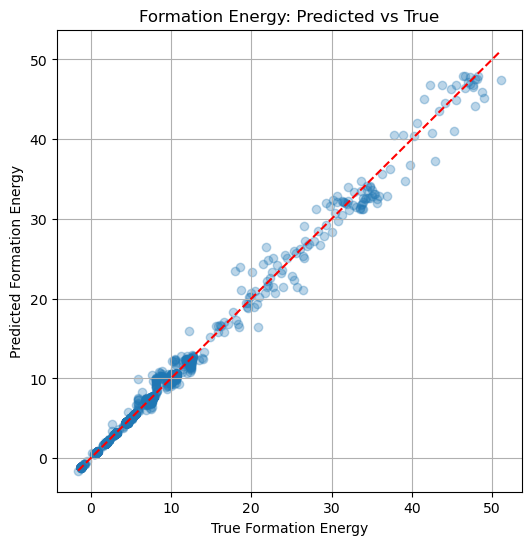

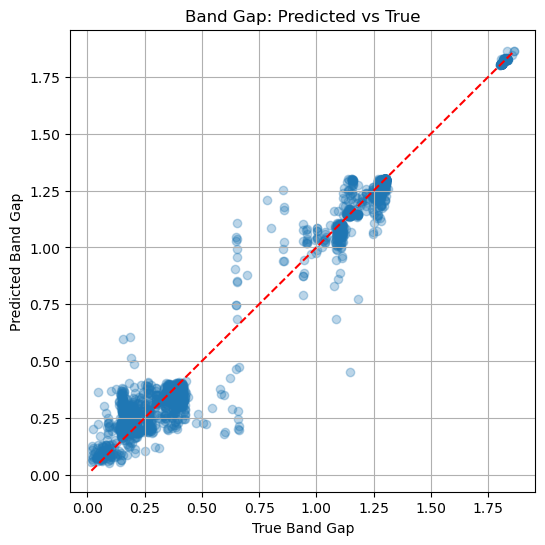

In [20]:
for y_true, y_pred, title in [
    (ye_te, y_pred_e, "Formation Energy"),
    (yg_te, y_pred_g, "Band Gap"),
]:
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    mn, mx = y_true.min(), y_true.max()
    plt.plot([mn, mx], [mn, mx], "r--")
    plt.xlabel(f"True {title}")
    plt.ylabel(f"Predicted {title}")
    plt.title(f"{title}: Predicted vs True")
    plt.grid(True)
    plt.show()

In [21]:
def show_feature_importances(pipeline, X_train, name, top_n=10):
    rf = pipeline.named_steps["randomforestregressor"]
    feat_names = X_train.columns
    importances = rf.feature_importances_
    imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
    print(f"\nTop {top_n} features for {name}:")
    print(imp.head(top_n))


show_feature_importances(pipe_e, Xe_tr, "Energy")

show_feature_importances(pipe_g, Xg_tr, "Band Gap")


Top 10 features for Energy:
nsites                        0.873081
atomic_numbers_std            0.074156
atomic_numbers_mean           0.017977
nspecies                      0.013918
voronoi_mean_nn_dist          0.013534
atomic_positions_mean_dist    0.003126
atomic_positions_std_dist     0.001984
voronoi_mean_neighbors        0.001169
base_WSe2                     0.000977
space_group_no                0.000078
dtype: float64

Top 10 features for Band Gap:
nsites                        0.521390
atomic_numbers_std            0.250767
voronoi_mean_nn_dist          0.201449
atomic_positions_mean_dist    0.011124
atomic_positions_std_dist     0.005128
nspecies                      0.003405
atomic_numbers_mean           0.003099
voronoi_mean_neighbors        0.002696
space_group_no                0.000932
base_WSe2                     0.000010
dtype: float64


attempt 2 - а давайте попробуем обучить ТОЛЬКО на voronoi фичах, интересно посмотреть что выдаст модель и сравнить с фулл набором фичей так еще и не на одной модели! мне кажется интересное идеей попробовать бустинги вместо лесов и сравнить, но хочу отметить что я все еще соблюдаю правила заданя так как основную модель (как раз лес) я тоже обучаю и валидирую

In [22]:
Y = np.vstack([y_energy, y_gap]).T  
X_all = X_energy
X_vor_feats = df[["voronoi_mean_neighbors", "voronoi_mean_nn_dist"]]
X_all_tr, X_all_te, Y_tr, Y_te = train_test_split(
    X_all, Y, test_size=0.2, random_state=42
)
X_vor_tr, X_vor_te, _, _ = train_test_split(
    X_vor_feats, Y, test_size=0.2, random_state=42
)

num_all = X_all_tr.select_dtypes(include=[np.number]).columns
num_vor = X_vor_tr.select_dtypes(include=[np.number]).columns
pre_e = ColumnTransformer(
    [("scale", StandardScaler(), num_all)], remainder="passthrough"
)
pre_v = ColumnTransformer(
    [("scale", StandardScaler(), num_vor)], remainder="passthrough"
)

pipe_rf_all = make_pipeline(
    pre_e, RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)
pipe_rf_vor = make_pipeline(
    pre_v, RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)
pipe_gb_all = make_pipeline(
    pre_e, MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
)
pipe_gb_vor = make_pipeline(
    pre_v, MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
)
pipe_cb_all = make_pipeline(
    pre_e, MultiOutputRegressor(CatBoostRegressor(verbose=0, random_state=42))
)
pipe_cb_vor = make_pipeline(
    pre_v, MultiOutputRegressor(CatBoostRegressor(verbose=0, random_state=42))
)

In [ ]:
def eval_multi_model(pipe, X_test, Y_test, name):
    Y_pred = pipe.predict(X_test)
    for idx, target_name in enumerate(["Formation Energy", "Band Gap"]):
        y_true = Y_test[:, idx]
        y_pred = Y_pred[:, idx]
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        print(f"{name} - {target_name}: RMSE={rmse:.4f}, MAE={mae:.4f}")
    print("---")


model_pipelines = [
    ("RF (All)", pipe_rf_all, X_all_tr),
    ("RF (Voronoi)", pipe_rf_vor, X_vor_tr),
    ("GB (All)", pipe_gb_all, X_all_tr),
    ("GB (Voronoi)", pipe_gb_vor, X_vor_tr),
    ("CatBoost (All)", pipe_cb_all, X_all_tr),
    ("CatBoost (Voronoi)", pipe_cb_vor, X_vor_tr),
]

for name, pipe, X_tr in model_pipelines:
    pipe.fit(X_tr, Y_tr)
    X_te = X_all_te if "All" in name else X_vor_te
    eval_multi_model(pipe, X_te, Y_te, name)

RF (All) - Formation Energy: RMSE=0.5784, MAE=0.1963
RF (All) - Band Gap: RMSE=0.0697, MAE=0.0377
---
RF (Voronoi) - Formation Energy: RMSE=1.9980, MAE=0.8421
RF (Voronoi) - Band Gap: RMSE=0.1724, MAE=0.0907
---
GB (All) - Formation Energy: RMSE=0.6415, MAE=0.2822
GB (All) - Band Gap: RMSE=0.0816, MAE=0.0468
---
GB (Voronoi) - Formation Energy: RMSE=2.4443, MAE=1.6419
GB (Voronoi) - Band Gap: RMSE=0.2422, MAE=0.1461
---
CatBoost (All) - Formation Energy: RMSE=0.6076, MAE=0.2218
CatBoost (All) - Band Gap: RMSE=0.0690, MAE=0.0385
---
CatBoost (Voronoi) - Formation Energy: RMSE=2.1588, MAE=1.2537
CatBoost (Voronoi) - Band Gap: RMSE=0.1976, MAE=0.1148
---


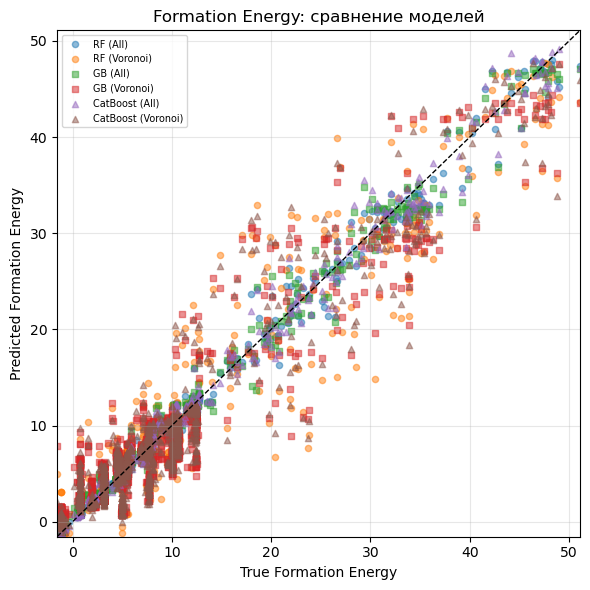

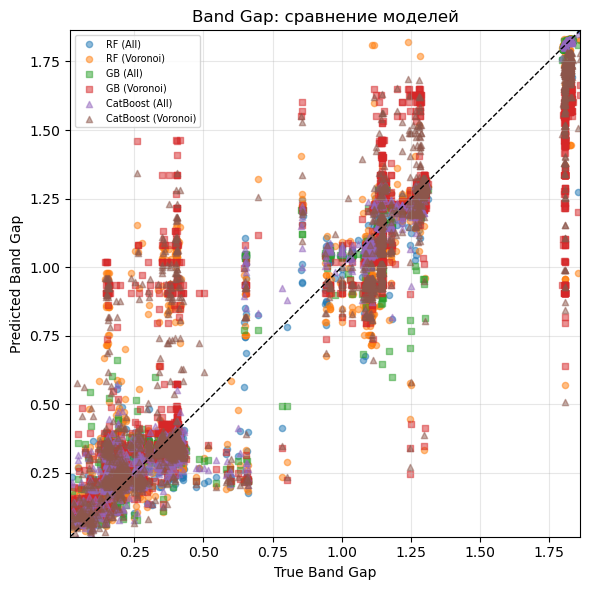

In [24]:
models = {name: pipe for name, pipe, _ in model_pipelines}

for title, idx in [("Formation Energy", 0), ("Band Gap", 1)]:
    fig, ax = plt.subplots(figsize=(6, 6))
    for name, model in models.items():
        X_te = X_all_te if "All" in name else X_vor_te
        y_true = Y_te[:, idx]
        y_pred = model.predict(X_te)[:, idx]
        marker = "o" if "RF" in name else ("s" if "GB" in name else "^")
        ax.scatter(y_true, y_pred, alpha=0.5, s=20, marker=marker, label=name)
    mn, mx = y_true.min(), y_true.max()
    ax.plot([mn, mx], [mn, mx], "k--", linewidth=1)
    ax.set_xlim(mn, mx)
    ax.set_ylim(mn, mx)
    ax.set_xlabel(f"True {title}")
    ax.set_ylabel(f"Predicted {title}")
    ax.set_title(f"{title}: сравнение моделей")
    ax.legend(loc="upper left", fontsize="x-small", frameon=True)
    ax.grid(alpha=0.3)
    fig.tight_layout()
    plt.show()

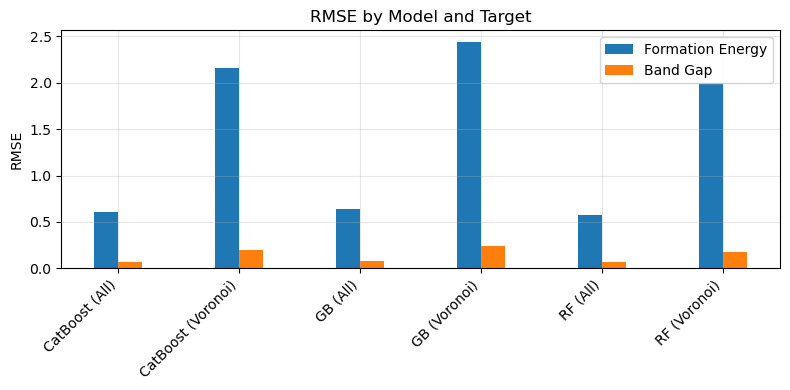

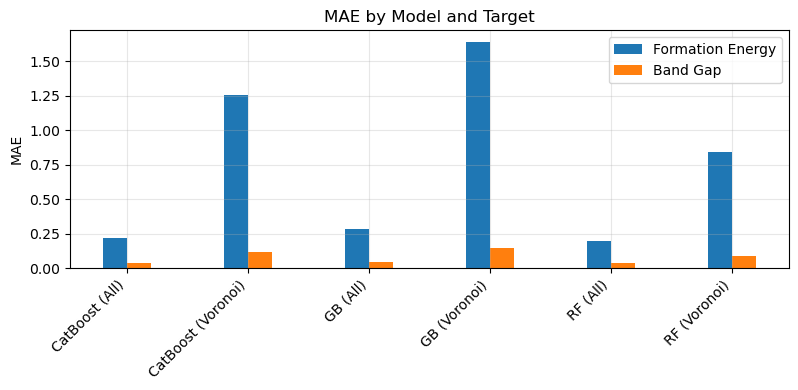

In [26]:
models = {name: pipe for name, pipe, _ in model_pipelines}
target_names = ["Formation Energy", "Band Gap"]
metrics = []
for name, model in models.items():
    for idx, target in enumerate(target_names):
        X_te = X_all_te if "All" in name else X_vor_te
        y_true = Y_te[:, idx]
        y_pred = model.predict(X_te)[:, idx]
        metrics.append(
            {
                "Model": name,
                "Target": target,
                "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
                "MAE": mean_absolute_error(y_true, y_pred),
            }
        )

df_metrics = pd.DataFrame(metrics)
for metric in ["RMSE", "MAE"]:
    pivot = df_metrics.pivot(index="Model", columns="Target", values=metric)
    x = np.arange(len(pivot))
    width = 0.2
    fig, ax = plt.subplots(figsize=(8, 4))
    for i, target in enumerate(target_names):
        ax.bar(x + (i - 0.5) * width, pivot[target], width, label=target)
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, rotation=45, ha="right")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by Model and Target")
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

/var/folders/md/1cwdxcj9029gzv7mhg8hkg480000gn/T/ipykernel_53955/979194623.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(residuals[t], labels=labels[t], patch_artist=True)


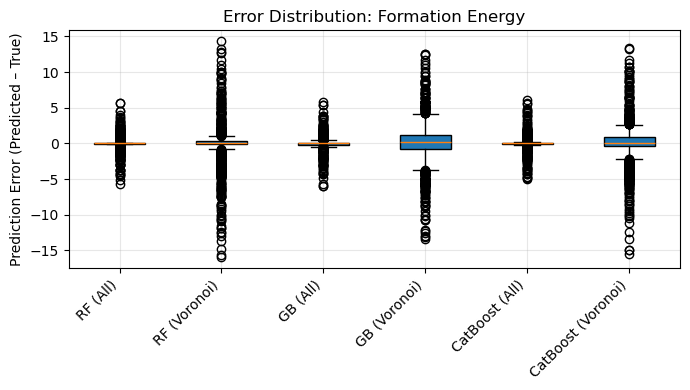

/var/folders/md/1cwdxcj9029gzv7mhg8hkg480000gn/T/ipykernel_53955/979194623.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(residuals[t], labels=labels[t], patch_artist=True)


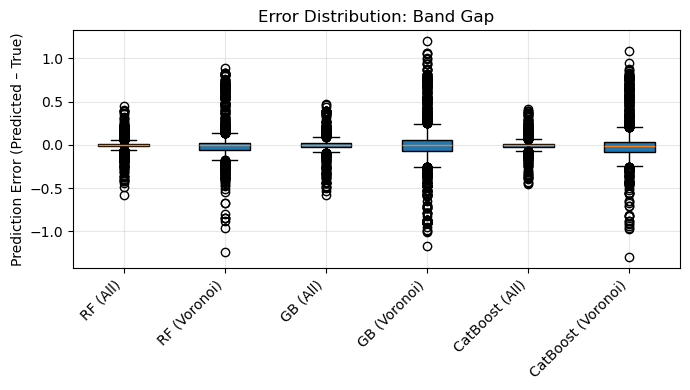

In [42]:
residuals = {t: [] for t in target_names}
labels = {t: [] for t in target_names}
for name, model in models.items():
    for idx, t in enumerate(target_names):
        X_te = X_all_te if "All" in name else X_vor_te
        y_true = Y_te[:, idx]
        y_pred = model.predict(X_te)[:, idx]
        residuals[t].append(y_pred - y_true)
        labels[t].append(name)

for t in target_names:
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.boxplot(residuals[t], labels=labels[t], patch_artist=True)
    ax.set_title(f"Error Distribution: {t}")
    ax.set_ylabel("Prediction Error (Predicted – True)")
    ax.set_xticklabels(labels[t], rotation=45, ha="right")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

так я хочу взглянуть на данные еще раз

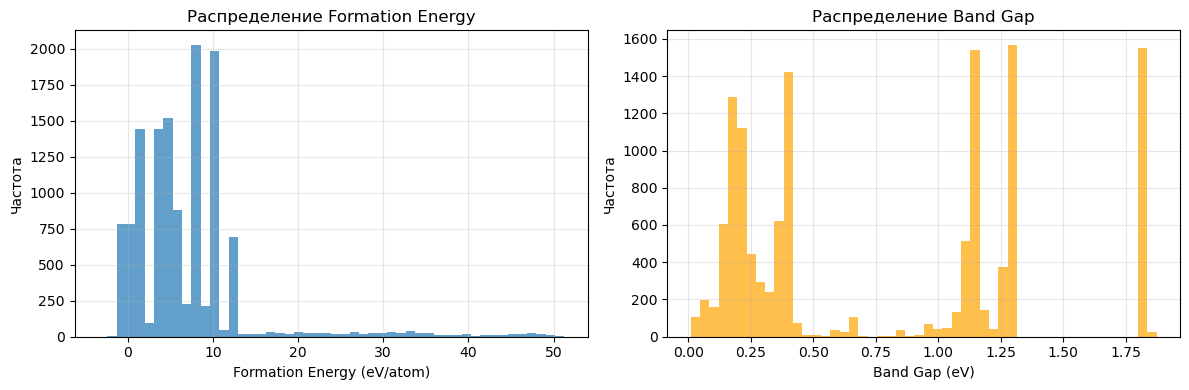

In [27]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(y_energy, bins=50, alpha=0.7)
plt.title('Распределение Formation Energy')
plt.xlabel('Formation Energy (eV/atom)')
plt.ylabel('Частота')
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.hist(y_gap, bins=50, alpha=0.7, color='orange')
plt.title('Распределение Band Gap')
plt.xlabel('Band Gap (eV)')
plt.ylabel('Частота')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


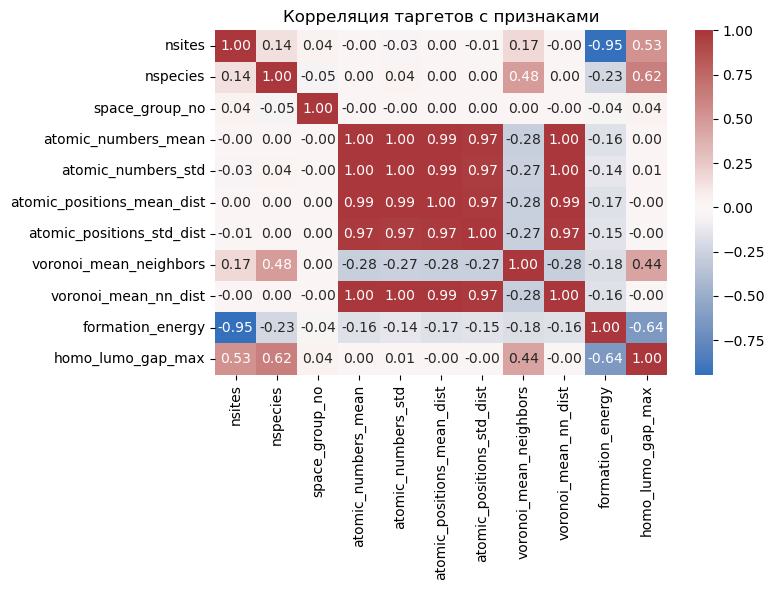

In [28]:
df_analysis = pd.concat(
    [
        pd.DataFrame(X_all.reset_index(drop=True)),
        pd.DataFrame(Y, columns=["formation_energy", "homo_lumo_gap_max"]),
    ],axis=1,
)
corr_feats = (base_feats + chem_feats + struct_feats + ["formation_energy", "homo_lumo_gap_max"])
corr_sub = df_analysis[corr_feats].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_sub, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Корреляция таргетов с признаками")
plt.tight_layout()
plt.show()

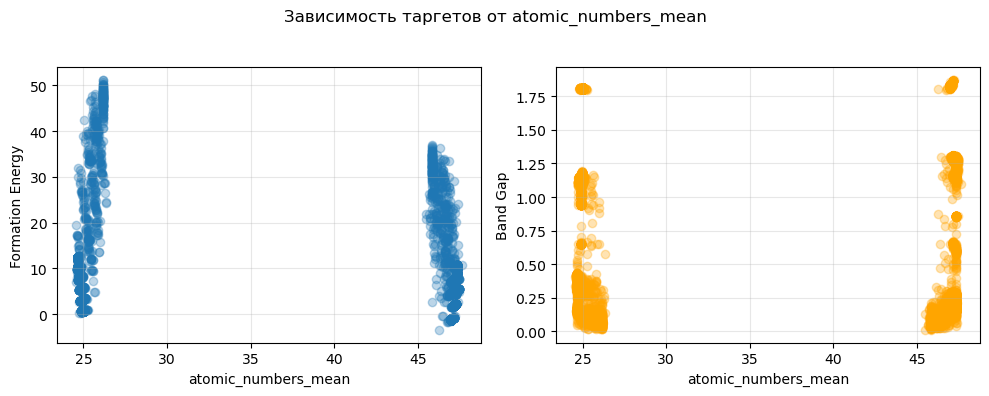

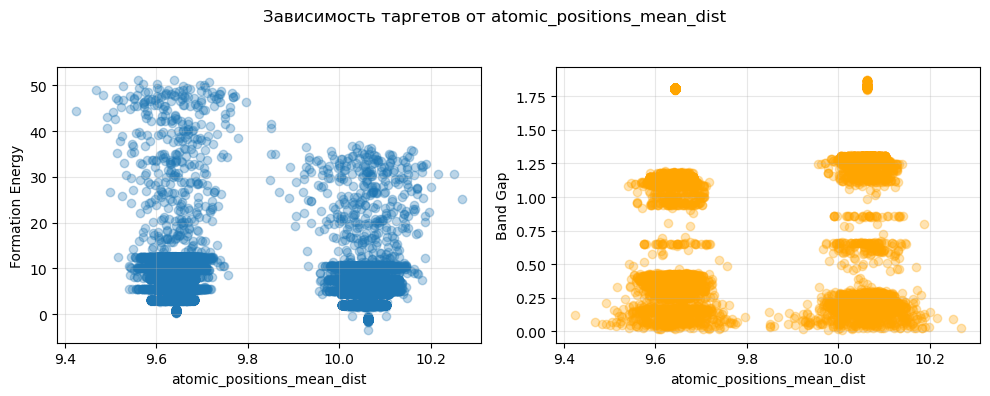

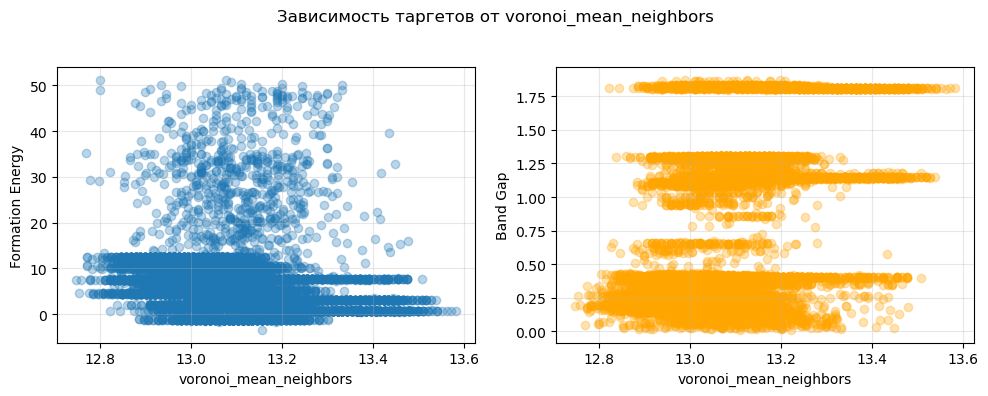

In [29]:
key_feats = [
    "atomic_numbers_mean",
    "atomic_positions_mean_dist",
    "voronoi_mean_neighbors",
]
for feat in key_feats:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].scatter(df[feat], y_energy, alpha=0.3)
    axes[0].set_xlabel(feat)
    axes[0].set_ylabel("Formation Energy")
    axes[0].grid(alpha=0.3)
    axes[1].scatter(df[feat], y_gap, alpha=0.3, color="orange")
    axes[1].set_xlabel(feat)
    axes[1].set_ylabel("Band Gap")
    axes[1].grid(alpha=0.3)
    fig.suptitle(f"Зависимость таргетов от {feat}")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Результаты
пойдем по порядку, но перед этим отмечу что я выполнил все условия задания так еще и провел мини ресерч, надеюсь он имеет мысло быть )

1) что лучше полный набор признаков или только voronoi?
одних геомитрических фичей voronoi мало тк они покрывают ток ср число соседей и расстояние, поэтому лучше всего комбинировать как и предложили авторы модели ибо метрики с фичами только voronoi значительно хуже

2) какая модель лучше на фулл фичах?
для таргета энергии лучше всего показывает себя случайный лес с rmse 0.5784 и mae 0.1963, катбуст чуток хуже а градиентный бустинг самый худший исход. для задачи band gap лучшая (но не сильно выделяется) модель это катбутс по метрике rmse но по мае снова лес впереди (а бустинг опять внизу где то). таким образом случайный лес показывает лучшую среднюю точнось для band gap, а катбуст более стабильный в минимизации редких но крупных ошибок.

3) какая модель лучше на voronoi фичах?
тут лес снова вырывается в топ для задачи энергии, а catboost и gb на одном уровне хуже. итог что даже если уреазть фичи лес все еще выдает неплохие резы а катбуст и бустинг чего то храмают

4) а что там по сравнению с другими решениями?
в целом есть всякие модели MEGNet CGCNN ALIGNN / Matformer и тд которые показали качество лучше чем мое по mae, но оно и не удивительно там и сетки глубокие а тут просто классик мо

5) а что там по графикам анализирующие данные?
как мы видим на графике запрещенной зоны то там видно что у нас по факту два явных пятна на графике, то есть скопление данных, это означает что модель может тупо начать угадывать в какой кластер попасть. а энергия наоборот скошена в одну сторону, но там и проблем меньше замечалось во время обучения

6) что я делал бы дальше?
ну так как пробовать можно много чего, я бы попробовал разделить задачу band gap на классификацю + регрессию, то есть ну видно что там gap в пиках и можно было бы попробовал сначала классифицировать материал по кластерам и затем внутри каждого класса обучить отдельную регрессию

    можно короч попробовать табличным дл решить задачу (ну это так я, не знаю как в реальности)
